preproc

In [16]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv("reduced_simple_for_lab_3_parsed_data_copy.csv")
df = df[df["Median"] != "-"]
df["Median"] = [float(i.replace(",", "")) for i in df["Median"].values]
df = df[df["Median"] < 1000]

In [17]:
X = df[["Artist", "Title", "Label", "Format", "Country", "Genre", "Have", "Want", "Ratings", "Style", "Median"]].copy()


def OneHotEncodeColumn(column_name):
    column_encoder = OneHotEncoder()
    return column_encoder.fit_transform(X[column_name].values.reshape(-1, 1)).toarray()


artists = OneHotEncodeColumn("Artist")
labels = OneHotEncodeColumn("Label")
formats = OneHotEncodeColumn("Format")
countries = OneHotEncodeColumn("Country")
genres = OneHotEncodeColumn("Genre")
style = OneHotEncodeColumn("Style")
scaler = StandardScaler()
X[["Have", "Want", "Ratings", "Median"]] = scaler.fit_transform(X[["Have", "Want", "Ratings", "Median"]])

X = np.concatenate((genres, style, X[["Have", "Want", "Ratings", "Median"]].values), axis=1)
y = np.argmax(formats, axis=1)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

my impl

In [19]:
def uniform_kernel(x):
    return 1 / 2 if abs(x) <= 1 else 0


def gaussian_kernel(x):
    return 1 / math.sqrt(2 * math.pi) * math.exp(-x ** 2 / 2)


def epanechnikov_kernel(x):
    return 3 / 4 * (1 - x ** 2) if abs(x) <= 1 else 0


def triangular_kernel(x):
    return 1 - abs(x) if abs(x) <= 1 else 0

In [68]:
from sklearn.neighbors import NearestNeighbors


class MyKnn:

    def __init__(self, k, fixed=False, kernel="uniform", metric="cosine"):
        self.weights = None
        self.X = None
        self.y = None
        self.finder = None
        self.k = k
        self.fixed = fixed
        self.kernel = {"uniform": uniform_kernel, "gaussian": gaussian_kernel, "epanechnikov": epanechnikov_kernel,
                       "triangular": triangular_kernel}[kernel]
        self.metric = metric

    def fit(self, X, y, weights=None):
        self.X = X
        self.y = y
        self.weights = weights
        if self.fixed:
            self.finder = NearestNeighbors(algorithm='auto', radius=self.k, metric=self.metric).fit(X)
        else:
            self.finder = NearestNeighbors(n_neighbors=self.k + 1, algorithm='auto', metric=self.metric).fit(X)

    def predict(self, x):
        distances, indices = self.finder.kneighbors(x)
        res = []
        for l, ind in enumerate(indices):
            if self.fixed:
                h = self.k
            else: 
                h = distances[l][-1]
            tmp = np.zeros(np.max(self.y) + 1)
            for i in range(len(ind) - 1):
                tmp[y[ind[i]]] += self.kernel(distances[l][i] / h) * (self.weights[ind[i]] if self.weights else 1)
            res.append(np.argmax(tmp))
        return res
    
    def closest(self, x):
        distances, indices = self.finder.kneighbors(x)
        return distances, indices
    
    def get_params(self, deep=True):
        return {"k": self.k,
                "fixed": self.fixed,
                "kernel": self.kernel,
                "metric": self.metric}


In [69]:
model = MyKnn(1, False, "uniform", "cosine")
model.fit(X_train, y_train)
model.closest(X_val[:1])

(array([[0.00210439, 0.00895674]]), array([[5182, 5199]]))

In [70]:
import optuna

def objective(trial):
    fixed = trial.suggest_categorical('fixed', [True, False])

    k = trial.suggest_int('k', 1, 151, step=10)

    kernel = trial.suggest_categorical('kernel', ["uniform", "gaussian", "epanechnikov", "triangular"])
    metric = trial.suggest_categorical("metric", ["euclidean", "cosine", "manhattan", "minkowski"])

    model = MyKnn(k, fixed, kernel, metric)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    score = accuracy_score(pred, y_val)
    return score

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

my_best_params = study.best_params
my_best_score = study.best_value

print("Best score:", my_best_score)
print("Best parameters:", my_best_params)

[I 2024-03-28 11:11:21,933] A new study created in memory with name: no-name-d046eb8a-4f7f-427c-9e9a-f378beec0662
[I 2024-03-28 11:11:22,051] Trial 0 finished with value: 0.660392798690671 and parameters: {'fixed': True, 'k': 61, 'kernel': 'epanechnikov', 'metric': 'minkowski'}. Best is trial 0 with value: 0.660392798690671.
[I 2024-03-28 11:11:22,607] Trial 1 finished with value: 0.6096563011456628 and parameters: {'fixed': True, 'k': 61, 'kernel': 'uniform', 'metric': 'cosine'}. Best is trial 0 with value: 0.660392798690671.
[I 2024-03-28 11:11:23,081] Trial 2 finished with value: 0.6579378068739771 and parameters: {'fixed': True, 'k': 111, 'kernel': 'triangular', 'metric': 'cosine'}. Best is trial 0 with value: 0.660392798690671.
[I 2024-03-28 11:11:23,152] Trial 3 finished with value: 0.6612111292962357 and parameters: {'fixed': True, 'k': 71, 'kernel': 'triangular', 'metric': 'minkowski'}. Best is trial 3 with value: 0.6612111292962357.
[I 2024-03-28 11:11:23,688] Trial 4 finished

Best score: 0.7311783960720131
Best parameters: {'fixed': False, 'k': 31, 'kernel': 'uniform', 'metric': 'manhattan'}


In [71]:
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, r2_score

def objective(trial):
    
    n_neighbors = trial.suggest_int('n_neighbors', 1, 151, step=10)
    weights = trial.suggest_categorical('weights', ["uniform", "distance"])
    metric = trial.suggest_categorical("metric", ["euclidean", "cosine", "manhattan", "minkowski"])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    score = accuracy_score(pred, y_val)
    return score

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

lib_best_params = study.best_params
lib_best_score = study.best_value

print("Best score:", lib_best_score)
print("Best parameters:", lib_best_params)

[I 2024-03-28 11:12:22,139] A new study created in memory with name: no-name-1e6d7646-8408-4c3b-b999-a24b5a9b7b91
[I 2024-03-28 11:12:22,233] Trial 0 finished with value: 0.7532733224222586 and parameters: {'n_neighbors': 51, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.7532733224222586.
[I 2024-03-28 11:12:22,361] Trial 1 finished with value: 0.7487725040916531 and parameters: {'n_neighbors': 91, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.7532733224222586.
[I 2024-03-28 11:12:22,954] Trial 2 finished with value: 0.752454991816694 and parameters: {'n_neighbors': 81, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.7532733224222586.
[I 2024-03-28 11:12:23,118] Trial 3 finished with value: 0.7508183306055647 and parameters: {'n_neighbors': 81, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.7532733224222586.
[I 2024-03-28 11:12:23,234] Trial 4 finished with value: 0.7565

Best score: 0.7647299509001637
Best parameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'manhattan'}


In [74]:
def draw_plot(X_train, y_train, X_val, y_val, model_constructor, args):
    res = []
    for i in tqdm(args):
        model = model_constructor(i)
        model.fit(X_train, y_train)
        score_train = accuracy_score(y_train, model.predict(X_train))
        score_val = accuracy_score(y_val, model.predict(X_val))
        res.append([score_train, score_val])

    plt.figure(figsize=(12, 4))
    print([i[0] for i in res])
    print([i[1] for i in res])
    plt.subplot(131)
    plt.plot(args, [i[0] for i in res])
    plt.title("train")

    plt.subplot(132)
    plt.plot(args, [i[1] for i in res])
    plt.title("valid")

    plt.tight_layout()
    plt.show()

def my_constructor(n):
    return MyKnn(k=n, fixed=my_best_params["fixed"], kernel=my_best_params["kernel"], metric=my_best_params["metric"])

def lib_constructor(n):
    return KNeighborsClassifier(n_neighbors=n, weights=lib_best_params["weights"], metric=lib_best_params["metric"])

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/6v/zsk4b6pj06bftc_2d241_k3r0000gn/T/ipykernel_74261/700806344.py:36: RuntimeWarning: invalid value encountered in scalar divide
  tmp[y[ind[i]]] += self.kernel(distances[l][i] / h) * (self.weights[ind[i]] if self.weights else 1)
100%|██████████| 10/10 [00:22<00:00,  2.30s/it]

[0.5923349699945445, 0.7129023458810693, 0.7285870158210583, 0.7352700490998363, 0.7354064375340971, 0.7354064375340971, 0.7354064375340971, 0.7354064375340971, 0.7354064375340971, 0.7354064375340971]
[0.6006546644844517, 0.7066284779050737, 0.7250409165302782, 0.7311783960720131, 0.7311783960720131, 0.7311783960720131, 0.7311783960720131, 0.7311783960720131, 0.7311783960720131, 0.7311783960720131]


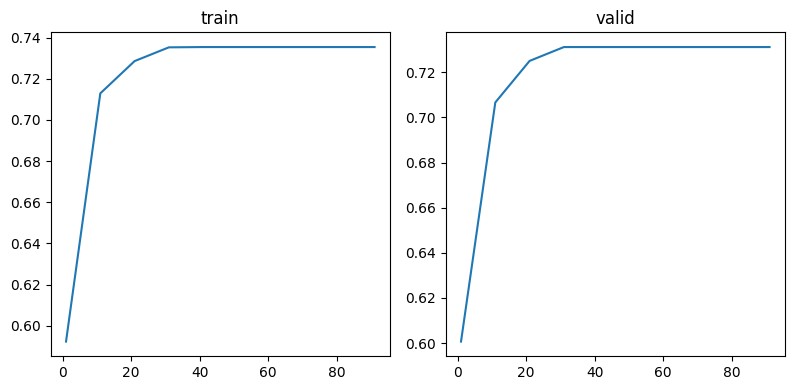

In [73]:
draw_plot(X_train, y_train, X_val, y_val, my_constructor, range(1, 101, 10))

100%|██████████| 10/10 [00:23<00:00,  2.39s/it]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.7131751227495908, 0.7569558101472995, 0.763911620294599, 0.7647299509001637, 0.7618657937806874, 0.7581833060556464, 0.7573649754500819, 0.7569558101472995, 0.7573649754500819, 0.7545008183306056]


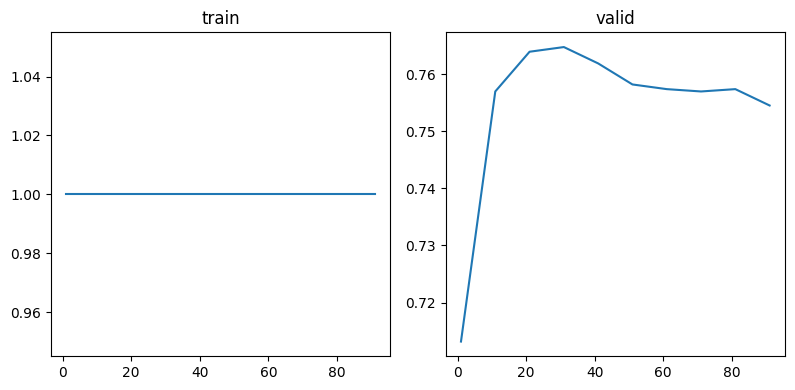

In [75]:
draw_plot(X_train, y_train, X_val, y_val, lib_constructor, range(1, 101, 10))

In [76]:
def lowess(X, y):
    weights = []
    for i in tqdm(range(len(X))):
        mask = np.ones(len(X), dtype=bool)
        mask[i] = False
        model = MyKnn(k=my_best_params["k"], fixed=my_best_params["fixed"], kernel=my_best_params["kernel"], metric=my_best_params["metric"])
        model.fit(X[mask], y[mask])
        weights.append(gaussian_kernel(y[i] - model.predict([X[i]])[0]))
    return weights

In [77]:
w = lowess(X_train, y_train)

100%|██████████| 7332/7332 [00:26<00:00, 278.53it/s]


In [78]:
model = MyKnn(k=my_best_params["k"], fixed=my_best_params["fixed"], kernel=my_best_params["kernel"], metric=my_best_params["metric"])
model.fit(X_train, y_train, weights=w)

In [79]:
accuracy_score(y_val, model.predict(X_val))

0.7315875613747954

In [80]:
mask = np.ones(len(X_train), dtype=bool)
percentile = np.percentile(w, 25)
for i in range(len(mask)):
    if w[i] < percentile:
        mask[i] = False
X_train_fil, y_train_fil = X_train[mask], y_train[mask]
model = KNeighborsClassifier(n_neighbors=lib_best_params["n_neighbors"], weights=lib_best_params["weights"], metric=lib_best_params["metric"])
model.fit(X_train_fil, y_train_fil)
pred = model.predict(X_val)

In [81]:
accuracy_score(pred, y_val)

0.7319967266775778